# Minimum Variance Portfolio Optimization with WRDS (CRSP Monthly Data)

This notebook demonstrates how to:
- Pull monthly stock return data from WRDS/CRSP
- Clean and validate coverage
- Estimate covariance matrices using **sample** and **Ledoit-Wolf shrinkage**
- Solve the **Global Minimum Variance (GMV)** portfolio with constraints
- Run a **rolling out-of-sample backtest**
- Compute metrics: annualized return, volatility, Sharpe ratio
- Analyze **turnover** and **weight stability**
- Export results and plots for reporting

In [2]:
pip install cvxpy

   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 3.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/887.3 kB ? eta -:--:--
   ----------------------- ---------------- 524.3/887.3 kB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 887.3/887.3 kB 3.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.8/7.5 MB 4.0 MB/s eta 0:00:02
   -------- ------------------------------- 1.6/7.5 MB 3.9 MB/s eta 0:00:02
   ------------ --------------------------- 2.4/7.5 MB 3.8 MB/s eta 0:00:02
   ---------------- ----------------------- 3.1/7.5 MB 3.8 MB/s eta 0:00:02
   --------------------- ------------------ 3.9/7.5 MB 3.8 MB/s eta 0:00:01
   ------------------------- -------------- 4.7/7.5 MB 3.8 MB/s eta 0:00:01
   ---------------------------

In [1]:
import os
import sys
import math
import numpy as np
import pandas as pd
import cvxpy as cp
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt

# default ticker universe
default_tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META",
                   "NVDA", "XOM", "JPM", "PG", "HD", "UNH", "V"]

# backtest parameters
start_date = "2015-01-01"
end_date   = "2025-06-30"
lookback_months = 36
lower_bound = -0.10
upper_bound =  0.20

# sharpe ratio risk-free rate (annual)
annual_rf = 0.02

### Get Monthly Returns from WRDS/CRSP

We query **CRSP monthly stock file (crsp.msf)** joined with `msenames` for tickers.
The query returns monthly simple returns for each ticker.


In [2]:
def get_crsp_monthly_returns(tickers, start, end, wrds_user = None):
    import wrds
    conn = wrds.Connection(wrds_username = wrds_user) if wrds_user else wrds.Connection()

    query = f"""
        select
            msf.date,
            msenames.ticker as ticker,
            msf.ret as ret
        from crsp.msf as msf
        join crsp.msenames as msenames
          on msf.permno = msenames.permno
         and msf.date between msenames.namedt and msenames.nameendt
        where msenames.ticker in ({','.join(["'" + t + "'" for t in tickers])})
          and msf.date between '{start}' and '{end}'
    """
    df = conn.raw_sql(query, date_cols = ["date"])
    conn.close()

    wide = (df.sort_values(["date", "ticker"])
              .pivot(index = "date", columns = "ticker", values = "ret")
              .sort_index())
    return wide

### Data Coverage Validation

We require each ticker to have sufficient non-missing history:
- Within each rolling window, allow at most `max_missing` gaps.
- Drop tickers that fail this test.
- Then drop any remaining rows with NaNs.


In [3]:
def filter_by_coverage(returns_wide, window_months, max_missing = 2):
    cols_to_keep = []
    for col in returns_wide.columns:
        ok = True
        for i in range(window_months, len(returns_wide)):
            window = returns_wide[col].iloc[i - window_months : i]
            if window.isna().sum() > max_missing:
                ok = False
                break
        if ok:
            cols_to_keep.append(col)
    return returns_wide[cols_to_keep]

def align_and_clean(returns_wide):
    return returns_wide.dropna(axis = 0, how = "any").sort_index()

### Covariance Estimators

- **Sample covariance**: standard historical estimate
- **Ledoit–Wolf shrinkage**: more stable estimator (reduces noise)


In [4]:
def sample_covariance(ret_window):
    return ret_window.cov().values

def ledoit_wolf_covariance(ret_window):
    lw = LedoitWolf().fit(ret_window.values)
    return lw.covariance_

### Global Minimum Variance Portfolio

We solve:

$$
\min_{w} \; w^T \Sigma w
$$

subject to:

$$\sum_i w_i = 1$$  
$$l \leq w_i \leq u \;\;\; \forall i$$  
**130/30 gross exposure constraints**:  
  $$\sum_i w_i^+ \leq 1.30, \quad \sum_i w_i^- \leq 0.30$$  

Where:
- **w** : vector of portfolio weights  
- **Σ** : covariance matrix of asset returns  
- **wᵢ** : weight of asset *i*  
- **l, u** : lower and upper bounds on each asset’s weight  
- **wᵢ⁺** : positive part of wᵢ (long exposure)  
- **wᵢ⁻** : negative part of wᵢ (short exposure)  


In [5]:
def gmv_weights(cov_matrix, lower = -0.1, upper = 0.2):
    n = cov_matrix.shape[0]
    w = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(w, cov_matrix))
    constraints = [cp.sum(w) == 1, w >= lower, w <= upper]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver = cp.OSQP, verbose = False)
    return np.array(w.value).ravel()

### Rolling Out-of-Sample Backtest

Each month:
- Estimate covariance using past `lookback_months`
- Solve GMV with sample and Ledoit-Wolf
- Record next-month realized return


In [6]:
def backtest_minvar(returns_wide, window_months = 36):
    dates = returns_wide.index
    tickers = list(returns_wide.columns)
    perf_rows, weight_rows = [], []

    for t in range(window_months, len(dates) - 1):
        est_window = returns_wide.iloc[t - window_months : t]
        next_ret = returns_wide.iloc[t + 1].values

        s_cov = sample_covariance(est_window)
        lw_cov = ledoit_wolf_covariance(est_window)

        w_sample = gmv_weights(s_cov, lower_bound, upper_bound)
        w_lw     = gmv_weights(lw_cov, lower_bound, upper_bound)

        perf_rows.append({
            "date": dates[t + 1],
            "sample_return": np.dot(w_sample, next_ret),
            "lw_return": np.dot(w_lw, next_ret)
        })

        for i, tic in enumerate(tickers):
            weight_rows.append({"date": dates[t], "method": "sample", "ticker": tic, "weight": w_sample[i]})
            weight_rows.append({"date": dates[t], "method": "ledoit_wolf", "ticker": tic, "weight": w_lw[i]})

    perf_df = pd.DataFrame(perf_rows).sort_values("date").reset_index(drop = True)
    perf_df["sample_cum"] = (1 + perf_df["sample_return"]).cumprod()
    perf_df["lw_cum"]     = (1 + perf_df["lw_return"]).cumprod()
    weights_df = pd.DataFrame(weight_rows)
    return perf_df, weights_df

### Performance Metrics

We compute:
- Annualized return
- Annualized volatility (std dev)
- Sharpe ratio (using annual risk-free rate)
- Portfolio turnover and weight stability


In [7]:
def annualize_mean_std(monthly_returns):
    mean_monthly = monthly_returns.mean()
    std_monthly  = monthly_returns.std(ddof = 1)
    ann_mean = (1 + mean_monthly) ** 12 - 1
    ann_std  = std_monthly * math.sqrt(12)
    return ann_mean, ann_std

def sharpe_ratio(monthly_returns, annual_rf = 0.02):
    monthly_rf = (1 + annual_rf) ** (1/12) - 1
    excess = monthly_returns - monthly_rf
    return math.sqrt(12) * (excess.mean() / excess.std(ddof = 1))

### Run Backtest


In [9]:
# fetch data (requires WRDS login)
returns_wide = get_crsp_monthly_returns(default_tickers, start_date, end_date)

# clean & filter
returns_clean = align_and_clean(filter_by_coverage(returns_wide, lookback_months))

# run backtest
perf_df, weights_df = backtest_minvar(returns_clean, lookback_months)

# summarize performance
summary = []
for label, col in [("sample", "sample_return"), ("ledoit_wolf", "lw_return")]:
    ann_mean, ann_std = annualize_mean_std(perf_df[col])
    sr = sharpe_ratio(perf_df[col], annual_rf)
    summary.append({"strategy": label, "annual_return": ann_mean,
                    "annual_volatility": ann_std, "sharpe_ratio": sr})
summary_df = pd.DataFrame(summary)
summary_df

Enter your WRDS username [dhaji]: dph865
Enter your password: ········


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  y


pgpass file created at C:\Users\dhaji\AppData\Roaming\postgresql\pgpass.conf
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


,strategy,annual_return,annual_volatility,sharpe_ratio
0,sample,0.137638,0.166820,0.658374
1,ledoit_wolf,0.143632,0.165424,0.696050


In [10]:
def drawdown_curve(cum):
    """
    cum : pd.Series of cumulative return (growth of $1)
    returns: dd (drawdown series), mdd (max drawdown as positive number)
    """
    peak = cum.cummax()
    dd = (cum / peak) - 1.0
    mdd = -dd.min()
    return dd, mdd

def calmar_ratio(annual_return, max_drawdown):
    """
    calmar = annual_return / max_drawdown (use positive mdd)
    """
    if max_drawdown == 0 or np.isnan(max_drawdown):
        return np.nan
    return annual_return / max_drawdown

def sortino_ratio(monthly_returns, annual_rf = 0.02):
    """
    sortino uses downside deviation (negatives only) relative to rf.
    """
    monthly_rf = (1.0 + annual_rf) ** (1.0 / 12.0) - 1.0
    excess = monthly_returns - monthly_rf
    downside = excess.copy()
    downside[downside > 0] = 0
    dd = np.sqrt((downside ** 2).mean())
    if dd == 0 or np.isnan(dd):
        return np.nan
    return np.sqrt(12.0) * (excess.mean() / dd)

def var_cvar(monthly_returns, alpha = 0.95):
    """
    historical VaR/CVaR (loss is positive number).
    VaR_95 = -quantile at 5%; CVaR_95 = mean of tail beyond VaR.
    """
    q = 1.0 - alpha
    sorted_ret = np.sort(monthly_returns.values)
    var = -np.quantile(sorted_ret, q)  # positive loss
    tail = sorted_ret[: max(1, int(len(sorted_ret) * q))]
    cvar = -np.mean(tail)
    return var, cvar

def hit_ratio(monthly_returns):
    return (monthly_returns > 0).mean()

def tracking_error(series_a, series_b):
    """
    monthly TE = std of active return; annualize by sqrt(12)
    """
    active = series_a - series_b
    te_m = active.std(ddof = 1)
    return te_m * math.sqrt(12.0)

def rolling_sharpe(monthly_returns, window = 12, annual_rf = 0.02):
    monthly_rf = (1.0 + annual_rf) ** (1.0 / 12.0) - 1.0
    excess = monthly_returns - monthly_rf
    rs = np.sqrt(12.0) * (excess.rolling(window).mean() / excess.rolling(window).std())
    return rs

def effective_n(weights_row):
    """
    effective number of holdings = 1 / sum(w_i^2).
    accepts a 1D np.array of weights.
    """
    hhi = np.sum(weights_row ** 2)
    return np.nan if hhi == 0 else 1.0 / hhi

def series_effective_n(weights_pivot):
    """
    weights_pivot: index=date, columns=ticker, values=weight
    returns a pd.Series of effective N by date
    """
    return weights_pivot.apply(lambda r: effective_n(r.values), axis = 1)

def series_hhi(weights_pivot):
    return (weights_pivot ** 2).sum(axis = 1)

In [11]:
# inputs expected from prior steps:
# - perf_df with columns: date, sample_return, lw_return, sample_cum, lw_cum
# - weights_df with columns: date, method, ticker, weight
# - turnover_df and stability_df (optional, but recommended)

# compute drawdowns and mdd
dd_sample, mdd_sample = drawdown_curve(perf_df["sample_cum"])
dd_lw,     mdd_lw     = drawdown_curve(perf_df["lw_cum"])

# compute classic stats
def summarize_one(label, ret_series, cum_series):
    ann_mean, ann_std = annualize_mean_std(ret_series)
    sr  = sharpe_ratio(ret_series, annual_rf = annual_rf)
    sor = sortino_ratio(ret_series, annual_rf = annual_rf)
    var95, cvar95 = var_cvar(ret_series, alpha = 0.95)
    dd, mdd = drawdown_curve(cum_series)
    calmar = calmar_ratio(ann_mean, mdd)
    hit = hit_ratio(ret_series)
    sk = ret_series.skew()
    kt = ret_series.kurt()  # excess kurtosis
    return pd.Series({
        "strategy": label,
        "annual_return": ann_mean,
        "annual_volatility": ann_std,
        "sharpe_ratio": sr,
        "sortino_ratio": sor,
        "var_95": var95,
        "cvar_95": cvar95,
        "max_drawdown": mdd,
        "calmar_ratio": calmar,
        "hit_ratio": hit,
        "skewness": sk,
        "excess_kurtosis": kt
    })

summary_plus = pd.concat([
    summarize_one("sample", perf_df["sample_return"], perf_df["sample_cum"]),
    summarize_one("ledoit_wolf", perf_df["lw_return"], perf_df["lw_cum"])
], axis = 1).T

# tracking error between the two strategies (annualized)
te_ann = tracking_error(perf_df["sample_return"], perf_df["lw_return"])
summary_plus.loc[:, "tracking_error_vs_other"] = [te_ann, te_ann]

# concentration metrics by method (time series -> summarize)
w_sample = (weights_df[weights_df["method"] == "sample"]
            .pivot(index = "date", columns = "ticker", values = "weight").sort_index())
w_lw     = (weights_df[weights_df["method"] == "ledoit_wolf"]
            .pivot(index = "date", columns = "ticker", values = "weight").sort_index())

effn_sample = series_effective_n(w_sample)
effn_lw     = series_effective_n(w_lw)
hhi_sample  = series_hhi(w_sample)
hhi_lw      = series_hhi(w_lw)

concentration_summary = pd.DataFrame({
    "method": ["sample", "ledoit_wolf"],
    "avg_effective_n": [effn_sample.mean(), effn_lw.mean()],
    "avg_hhi": [hhi_sample.mean(), hhi_lw.mean()]
})

# export all tables
from pathlib import Path
out_dir = Path("outputs")
out_dir.mkdir(parents = True, exist_ok = True)

summary_plus.to_csv(out_dir / "summary_metrics_extended.csv", index = False)
concentration_summary.to_csv(out_dir / "concentration_summary.csv", index = False)
effn_sample.rename("effective_n").to_csv(out_dir / "effective_n_sample_ts.csv", header = True)
effn_lw.rename("effective_n").to_csv(out_dir / "effective_n_ledoitwolf_ts.csv", header = True)
hhi_sample.rename("hhi").to_csv(out_dir / "hhi_sample_ts.csv", header = True)
hhi_lw.rename("hhi").to_csv(out_dir / "hhi_ledoitwolf_ts.csv", header = True)

summary_plus, concentration_summary

(      strategy annual_return annual_volatility sharpe_ratio sortino_ratio  \
 0       sample      0.137638           0.16682     0.658374      1.030687   
 1  ledoit_wolf      0.143632          0.165424      0.69605      1.091499   
 
      var_95   cvar_95 max_drawdown calmar_ratio hit_ratio  skewness  \
 0  0.076432  0.093105     0.262063     0.525208  0.638554 -0.284182   
 1  0.076576  0.093281     0.254349     0.564705  0.638554  -0.32531   
 
   excess_kurtosis  tracking_error_vs_other  
 0       -0.180506                 0.011548  
 1       -0.153696                 0.011548  ,
         method  avg_effective_n   avg_hhi
 0       sample         4.676688  0.215917
 1  ledoit_wolf         5.444892  0.185856)

In [12]:
# extended summary table (returns, vol, sharpe, sortino, drawdown, etc.)
summary_plus

,strategy,annual_return,annual_volatility,sharpe_ratio,sortino_ratio,var_95,cvar_95,max_drawdown,calmar_ratio,hit_ratio,skewness,excess_kurtosis,tracking_error_vs_other
0,sample,0.137638,0.16682,0.658374,1.030687,0.076432,0.093105,0.262063,0.525208,0.638554,-0.284182,-0.180506,0.011548
1,ledoit_wolf,0.143632,0.165424,0.69605,1.091499,0.076576,0.093281,0.254349,0.564705,0.638554,-0.32531,-0.153696,0.011548


In [13]:
# concentration summary (HHI and effective N)
concentration_summary

,method,avg_effective_n,avg_hhi
0,sample,4.676688,0.215917
1,ledoit_wolf,5.444892,0.185856


In [14]:
# time series of effective N for each method (show last few)
pd.DataFrame({
    "sample_effective_n": effn_sample,
    "ledoit_wolf_effective_n": effn_lw
}).tail()

,sample_effective_n,ledoit_wolf_effective_n
date,,
2024-07-31,5.303928,5.889062
2024-08-30,5.313256,5.902694
2024-09-30,5.302788,5.882564
2024-10-31,5.450236,5.983649
2024-11-29,4.128856,5.468801


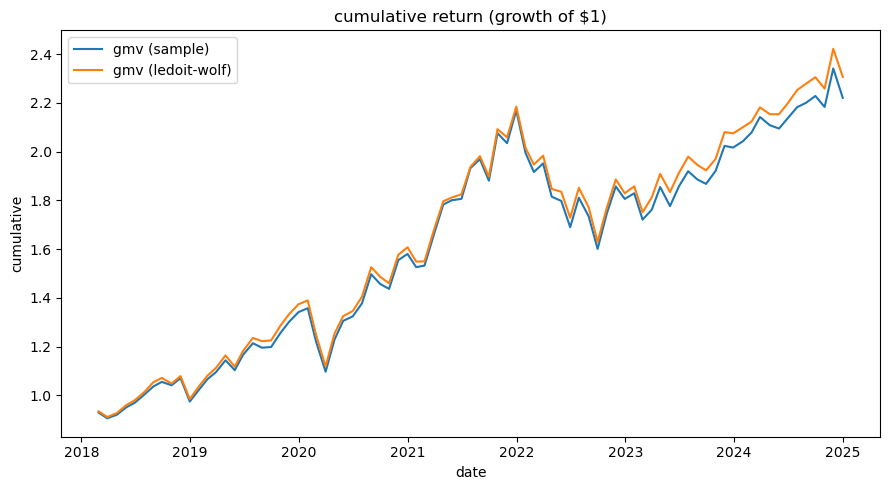

In [15]:
plt.figure(figsize=(9,5))
plt.plot(perf_df["date"], perf_df["sample_cum"], label="gmv (sample)")
plt.plot(perf_df["date"], perf_df["lw_cum"], label="gmv (ledoit-wolf)")
plt.title("cumulative return (growth of $1)")
plt.xlabel("date")
plt.ylabel("cumulative")
plt.legend()
plt.tight_layout()
plt.show()